# **SUPERVISED LEARNING**

This dataset contains data for all loans issued during the period 2007-2011, including the current status of the loan (current, written off, fully repaid, etc.) and the most recent repayment information

**Objetive:**

Find the model and its set of hyperparameters that best predict whether a loan is risky or not. The aim is to obtain a model that can be used to predict whether a customer, based on certain characteristics, is suitable for purchasing the financial product.

Target/prediction objective:
* **bad_loans**: (+1 means credit risk, 0 is safe)

## **Predefined Functions**

In [129]:
import warnings
warnings.filterwarnings('ignore')

In [130]:
# Hacer print con el texto en negrita
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [131]:
# Creamos una función que imprime por pantalla características importantes de los datos
def inspect_data(df):
    printmd('Data Shape')
    print(df.shape)
    print('\n')
    printmd('Missing Values: ')
    print(df.isnull().sum())
    print('\n')
    printmd('Data Types: ')
    print(df.dtypes)

In [132]:
def plottingRegressComparison(yreal,ypred):

    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})

    i=min(ypred)
    comparison["line"] = [i+j*max(yreal)/len(comparison) for j in range(len(comparison))]
    comparison["line2"] = comparison["line"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison.plot(x="line", y="line2", ax=ax, color="red", marker="*", markersize=2)
    comparison.plot.scatter(x="yreal", y="ypred", ax=ax)
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_xticklabels(ax.get_xticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_ylabel("Ventas predichas", fontname='Serif', fontsize=10)
    ax.set_xlabel("Ventas reales", fontname='Serif', fontsize=10)
    ax.set_title("Ventas reales VS Ventas predichas", fontname='Serif', fontsize=10)
    ax.get_legend().remove()

In [133]:
def plottingResults(yreal,ypred):
    # Creamos
    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})
    comparison["diff"] = comparison["yreal"] - comparison["ypred"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison["diff"].hist(bins=100, ax=ax)
    ax.set_xticklabels(ax.get_xticks(),fontsize=10, rotation=45)
    ax.set_yticklabels(ax.get_yticks(),fontsize=10)
    ax.set_xlabel("Error", fontname='Serif', fontsize=10)
    ax.set_title("Histograma del error de predicción", fontname='Serif', fontsize=16)

## **Preprocessing Functions**

### Missing data

In [134]:
def meanValueImputation(data, feature):
    """
    Completa los valores vacíos en una columna de un DataFrame con el valor medio de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor medio de la columna
    valor_medio = data[feature].mean()

    # Completa los valores vacíos con el valor medio
    data[feature].fillna(valor_medio, inplace=True)

In [135]:
from scipy import stats
def modeValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna de un DataFrame con el valor moda de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor moda de la columna
    valor_moda = stats.mode(data[feature])[0][0]

    # Completa los valores vacíos con el valor moda
    data[feature].fillna(valor_moda, inplace=True)

In [136]:
def mostCommonValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna categórica de un DataFrame con el valor más común (modo) de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor más común (modo) de la columna
    valor_mas_comun = data[feature].mode()[0]

    # Completa los valores vacíos con el valor más común
    data[feature].fillna(valor_mas_comun, inplace=True)

### Outliers

In [137]:
def statisticalOutlierDetection(data, feature, thresholdmin=None,thresholdmax=None, drop=False):
  #Eliminamos outliers en base a un criterio estadístico
  if thresholdmax:
    print("dentro")
    data_clean = data.drop(data[data[feature]>=thresholdmax].index)
  else:
    data_clean = data.copy()

  if thresholdmin:
    data_clean = data_clean.drop(data_clean[data_clean[feature]<=thresholdmin].index)
  else:
    data_clean = data_clean.copy()

  data_clean.reset_index(drop=True, inplace=True)

  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))
  print(data_clean.shape)

  if drop==True:
    return data_clean
  else:
    return data

In [138]:
def modelOutlierDetection(data, nf, n = 20, drop = False):
  ## LocalOutlierFactor: se basa en la idea de que las instancias de datos anómalas tienen una densidad de puntos diferente a la de las instancias de datos normales en su vecindario local.
  from sklearn.neighbors import LocalOutlierFactor
  # Creamos el objeto LOF y ajustamos los datos
  clf = LocalOutlierFactor(n_neighbors=n)  # número de vecinos más cercanos que se considerarán al calcular la densidad local de un punto de datos.
  y_pred = clf.fit_predict(np.array(nf))
  # Eliminamos los outliers de nuestro set de datos
  data_clean = data.copy()
  data_clean["outliers"] = y_pred
  data_clean.drop(data_clean[data_clean["outliers"]<0].index, inplace=True)
  data_clean.drop("outliers", axis=1, inplace=True)
  data_clean.reset_index(drop=True, inplace=True)
  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))

  if drop:
    return  data_clean
  else:
    return data

### Encoding

In [139]:
from sklearn.preprocessing import LabelEncoder
def labelEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  le = LabelEncoder()
  data_cod = data.copy() # Creo un dataframe de plantilla porque no quiero modificar el original
  for col in categorical_features.columns:
      data_cod[col+"_cod"]=le.fit_transform(np.array(data_cod[col]))

  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [140]:
from sklearn.preprocessing import OneHotEncoder
def OHEncoding(data, categorical_features):
  ohe = OneHotEncoder()
  data_cod = data.copy()
  for col in categorical_features.columns:
    # Data a codificar
    X = np.array(data_cod[[col]])
    # Fit & transform
    ohe.fit(X)
    Xohe = ohe.transform(X).toarray()
    # Unimos al set de datos de partida
    dataohe = pd.DataFrame(Xohe, columns=data_cod[col].drop_duplicates().tolist())
    data_cod = pd.concat([data_cod,dataohe], axis=1)

  # Eliminamos las variables originales de nuestro set de datos
  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [141]:
!pip install category_encoders
import category_encoders as ce
def binaryEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  data_cod = data.copy()
  # Creamos el objeto BinaryEncoder y ajustamos el dataframe
  encoder = ce.BinaryEncoder(cols=categorical_features)
  data_cod = encoder.fit_transform(data_cod)
  data_cod

  return data_cod

### Escalers

In [142]:
#MinMaxScaler

"""
scalers = {}
inf = {}

for i in data_cod.columns:
    minmax = MinMaxScaler()
    scalers[i+"scl"] = minmax.fit(data_cod[[i]])
    inf[i+"scl"] = minmax.transform(data_cod[[i]]).reshape(-1) #se transforman los datos de la columna utilizando el MinMaxScaler (minmax.transform), y se aplana el resultado usando reshape(-1)

    data_scl = pd.DataFrame(inf)

data_scl.head()
"""

'\nscalers = {}\ninf = {}\n\nfor i in data_cod.columns:\n    minmax = MinMaxScaler()\n    scalers[i+"scl"] = minmax.fit(data_cod[[i]])\n    inf[i+"scl"] = minmax.transform(data_cod[[i]]).reshape(-1) #se transforman los datos de la columna utilizando el MinMaxScaler (minmax.transform), y se aplana el resultado usando reshape(-1)\n\n    data_scl = pd.DataFrame(inf)\n\ndata_scl.head()\n'

In [143]:
#StandardScaler

"""
scalers = {}
inf = {}
for i in data_cod.columns:
  std_scaler = StandardScaler()
  scalers[i+"scl"] = std_scaler.fit(data_cod[[i]])#.reshape(-1)
  inf[i+"scl"] = std_scaler.transform(data_cod[[i]]).reshape(-1)

data_scl = pd.DataFrame(inf)

data_scl.head()
"""

'\nscalers = {}\ninf = {}\nfor i in data_cod.columns:\n  std_scaler = StandardScaler()\n  scalers[i+"scl"] = std_scaler.fit(data_cod[[i]])#.reshape(-1)\n  inf[i+"scl"] = std_scaler.transform(data_cod[[i]]).reshape(-1)\n\ndata_scl = pd.DataFrame(inf)\n\ndata_scl.head()\n'

### -------------------

## **Data Upload and Preview**

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [145]:
df = pd.read_csv("data/challenge-lending_club_data_train.csv")
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,...,not_compliant,status,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,20111201T000000,...,0,Fully Paid,1,0,11,5,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,20111201T000000,...,0,Charged Off,1,1,1,4,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,20111201T000000,...,0,Fully Paid,1,0,11,4,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,20111201T000000,...,0,Fully Paid,1,0,11,4,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,20111201T000000,...,0,Fully Paid,1,0,4,6,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## **First Analysis of Each Variable**

In [146]:
columns = df.columns
columns.unique()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [147]:
for i in columns:
  print(df[i].head(2))

0    1077501
1    1077430
Name: id, dtype: int64
0    1296599
1    1314167
Name: member_id, dtype: int64
0    5000
1    2500
Name: loan_amnt, dtype: int64
0    5000
1    2500
Name: funded_amnt, dtype: int64
0    4975
1    2500
Name: funded_amnt_inv, dtype: int64
0     36 months
1     60 months
Name: term, dtype: object
0    10.65
1    15.27
Name: int_rate, dtype: float64
0    162.87
1     59.83
Name: installment, dtype: float64
0    B
1    C
Name: grade, dtype: object
0    B2
1    C4
Name: sub_grade, dtype: object
0      NaN
1    Ryder
Name: emp_title, dtype: object
0    10+ years
1     < 1 year
Name: emp_length, dtype: object
0    RENT
1    RENT
Name: home_ownership, dtype: object
0    24000.0
1    30000.0
Name: annual_inc, dtype: float64
0           Verified
1    Source Verified
Name: is_inc_v, dtype: object
0    20111201T000000
1    20111201T000000
Name: issue_d, dtype: object
0     Fully Paid
1    Charged Off
Name: loan_status, dtype: object
0    n
1    n
Name: pymnt_plan, dtype: o

In [148]:
variable = df['short_emp']
variable.unique()

array([0, 1])

In [149]:
variable = df['pymnt_plan']
variable.unique()

array(['n'], dtype=object)

In [150]:
variable = df['initial_list_status']
variable.unique()

array(['f', 'w'], dtype=object)

In [151]:
variable = df['mths_since_last_major_derog']
variable.unique()

array([ nan,  69.,  62.,  74.,  10.,  27.,  56.,  61.,  34.,  25.,  46.,
        63.,  48.,  57.,  68.,  60.,  65.,  30.,  41.,  71.,  16.,  73.,
        75.,  45.,  33.,  13.,   5.,  64.,  21.,  50.,  44.,  38.,  59.,
        47.,  29.,  52.,  39.,  24.,  94.,  37.,  79.,  66.,  35.,  11.,
        58.,  19.,  67.,  17.,  31.,   1.,  76.,  84.,  70.,   8.,  20.,
        22.,  42.,   7.,  18.,  54.,  36.,  43.,  55.,  40.,   2.,  77.,
        72.,  14.,  15.,   4.,   3.,  51.,  53.,  23., 100.,  12.,  49.,
       102.,  80.,   9.,  28.,  78.,  81.,  26., 152.,  92.,  88.,   6.,
        32.,  82.,  83.,  87.,   0.,  91.,  89.,  86., 122., 101., 113.,
        96., 139., 109.,  90., 148.])

In [152]:
variable = df['inactive_loans']
variable.unique()

array([1])

In [153]:
variable = df['emp_length'] #me quedo con emp_length_num
variable.unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years',
       nan], dtype=object)

In [154]:
variable = df['grade'] #me quedo con grade_num
variable.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [155]:
variable = df['last_major_derog_none']
variable.unique()

array([1, 0])

In [156]:
variable = df['delinq_2yrs_zero'] #similar a delinq_2yrs
variable.unique()

array([ 1.,  0., nan])

In [157]:
variable = df['pub_rec'] #similar a pub_rec_zero
variable.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan,  6., 10.,  7.])

At first glance, I will remove the following columns that I consider irrelevant:

- desc (description)
- earliest_cr_line (date)
- emp_lenght (same as emp_lenght_num)
- grade (same as grade_num)
- id (index)
- issue_d (date)
- last_credit_pull_d (date)
- last_pymnt_d (date)
- member_id (id)
- mths_since_last_delinq (date)
- mths_since_last_record (date)
- next_pymnt_d (date)
- pymnt_plan (array(['n']))
- sub_grade (same as sub_grade_num)
- title
- url
- zip_code
- inactive_loans (array([1]))
- delinq_2yrs_zero (same as delinq_2yrs)
- pub_rec_zero (same as pub_rec)
- collections_12_mths_zero
- short_emp (no information, contains only 0 and 1)
- final_d (date column)
- last_record_none (no information)
- last_major_derog_none (similar to last_delinq_none)
- policy_code (has only 1 value)


## **Second Analysis of Each Variable**

**- Remaining columns:** addr_state, annual_inc, collection_recovery_fee, collections_12_mths_ex_med, delinq_2yrs, dti, emp_title, funded_amnt, funded_amnt_inv, home_ownership, initial_list_status, inq_last_6mths, installment, int_rate, last_pymnt_amnt, loan_amnt, loan_status, mths_since_last_major_derog, open_acc, out_prncp, out_prncp_inv, pub_rec, purpose, recoveries, revol_bal, revol_util, term, total_acc, total_pymnt, total_pymnt_inv, total_rec_int, total_rec_late_fee, is_inq_v, not_compliant, status, bad_loans, emp_length_num, grade_num, sub_grade_num, payment_inc_ratio, last_delinq_none

In [158]:
df = df[['addr_state', 'annual_inc', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'emp_title', 'funded_amnt',
         'funded_amnt_inv', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'last_pymnt_amnt',
         'loan_amnt', 'loan_status', 'mths_since_last_major_derog', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec',
         'purpose', 'recoveries', 'revol_bal', 'revol_util', 'term', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
         'not_compliant', 'status', 'bad_loans', 'emp_length_num', 'grade_num', 'sub_grade_num', 'payment_inc_ratio', 'last_delinq_none']]

In [159]:
df.head(3)

,addr_state,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,emp_title,funded_amnt,funded_amnt_inv,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,...,revol_bal,revol_util,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,not_compliant,status,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
0,AZ,24000.0,0.00,0.0,0.0,27.65,NaN,5000,4975,RENT,f,1.0,162.87,10.65,171.62,5000,...,13648,83.7,36 months,9.0,5861.07,5831.78,861.07,0.0,0,Fully Paid,0,11,5,0.4,8.14350,1
1,GA,30000.0,1.11,0.0,0.0,1.00,Ryder,2500,2500,RENT,f,5.0,59.83,15.27,119.66,2500,...,1687,9.4,60 months,4.0,1008.71,1008.71,435.17,0.0,0,Charged Off,1,1,4,0.8,2.39320,1
2,IL,12252.0,0.00,0.0,0.0,8.72,NaN,2400,2400,RENT,f,2.0,84.33,15.96,649.91,2400,...,2956,98.5,36 months,10.0,3003.65,3003.65,603.65,0.0,0,Fully Paid,0,11,4,1.0,8.25955,1


- Categorical Variables:

In [160]:
categorical_features = df.select_dtypes(include=[object])
categorical_features.head(2)

,addr_state,emp_title,home_ownership,initial_list_status,loan_status,purpose,term,status
0,AZ,NaN,RENT,f,Fully Paid,credit_card,36 months,Fully Paid
1,GA,Ryder,RENT,f,Charged Off,car,60 months,Charged Off


In [161]:
categorical_features.apply(lambda x : len(x.unique()))

addr_state                50
emp_title              54463
home_ownership             4
initial_list_status        2
loan_status                5
purpose                   12
term                       2
status                     3
dtype: int64

In [162]:
variable = df['addr_state']
variable.unique()

array(['AZ', 'GA', 'IL', 'CA', 'TX', 'VA', 'MO', 'CT', 'UT', 'FL', 'NY',
       'PA', 'MN', 'NJ', 'OR', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA', 'WA',
       'WI', 'AL', 'NV', 'CO', 'MD', 'WV', 'VT', 'MI', 'DC', 'SD', 'NC',
       'AR', 'KS', 'NM', 'HI', 'AK', 'OK', 'MT', 'WY', 'NH', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME'], dtype=object)

In [163]:
variable = df['emp_title']
variable.unique()

array([nan, 'Ryder', 'AIR RESOURCES BOARD', ...,
       'Douglas County Highway Department', 'FRITOLAY',
       'Pacific University'], dtype=object)

**I remove** the job title and state address, as they have many unique values, which requires more computational resources.

In [164]:
drop_columns = ['addr_state', 'emp_title']
df = df.drop(drop_columns, axis=1)

In [165]:
categorical_features = df.select_dtypes(include=[object])
categorical_features.head()

,home_ownership,initial_list_status,loan_status,purpose,term,status
0,RENT,f,Fully Paid,credit_card,36 months,Fully Paid
1,RENT,f,Charged Off,car,60 months,Charged Off
2,RENT,f,Fully Paid,small_business,36 months,Fully Paid
3,RENT,f,Fully Paid,other,36 months,Fully Paid
4,RENT,f,Fully Paid,wedding,36 months,Fully Paid


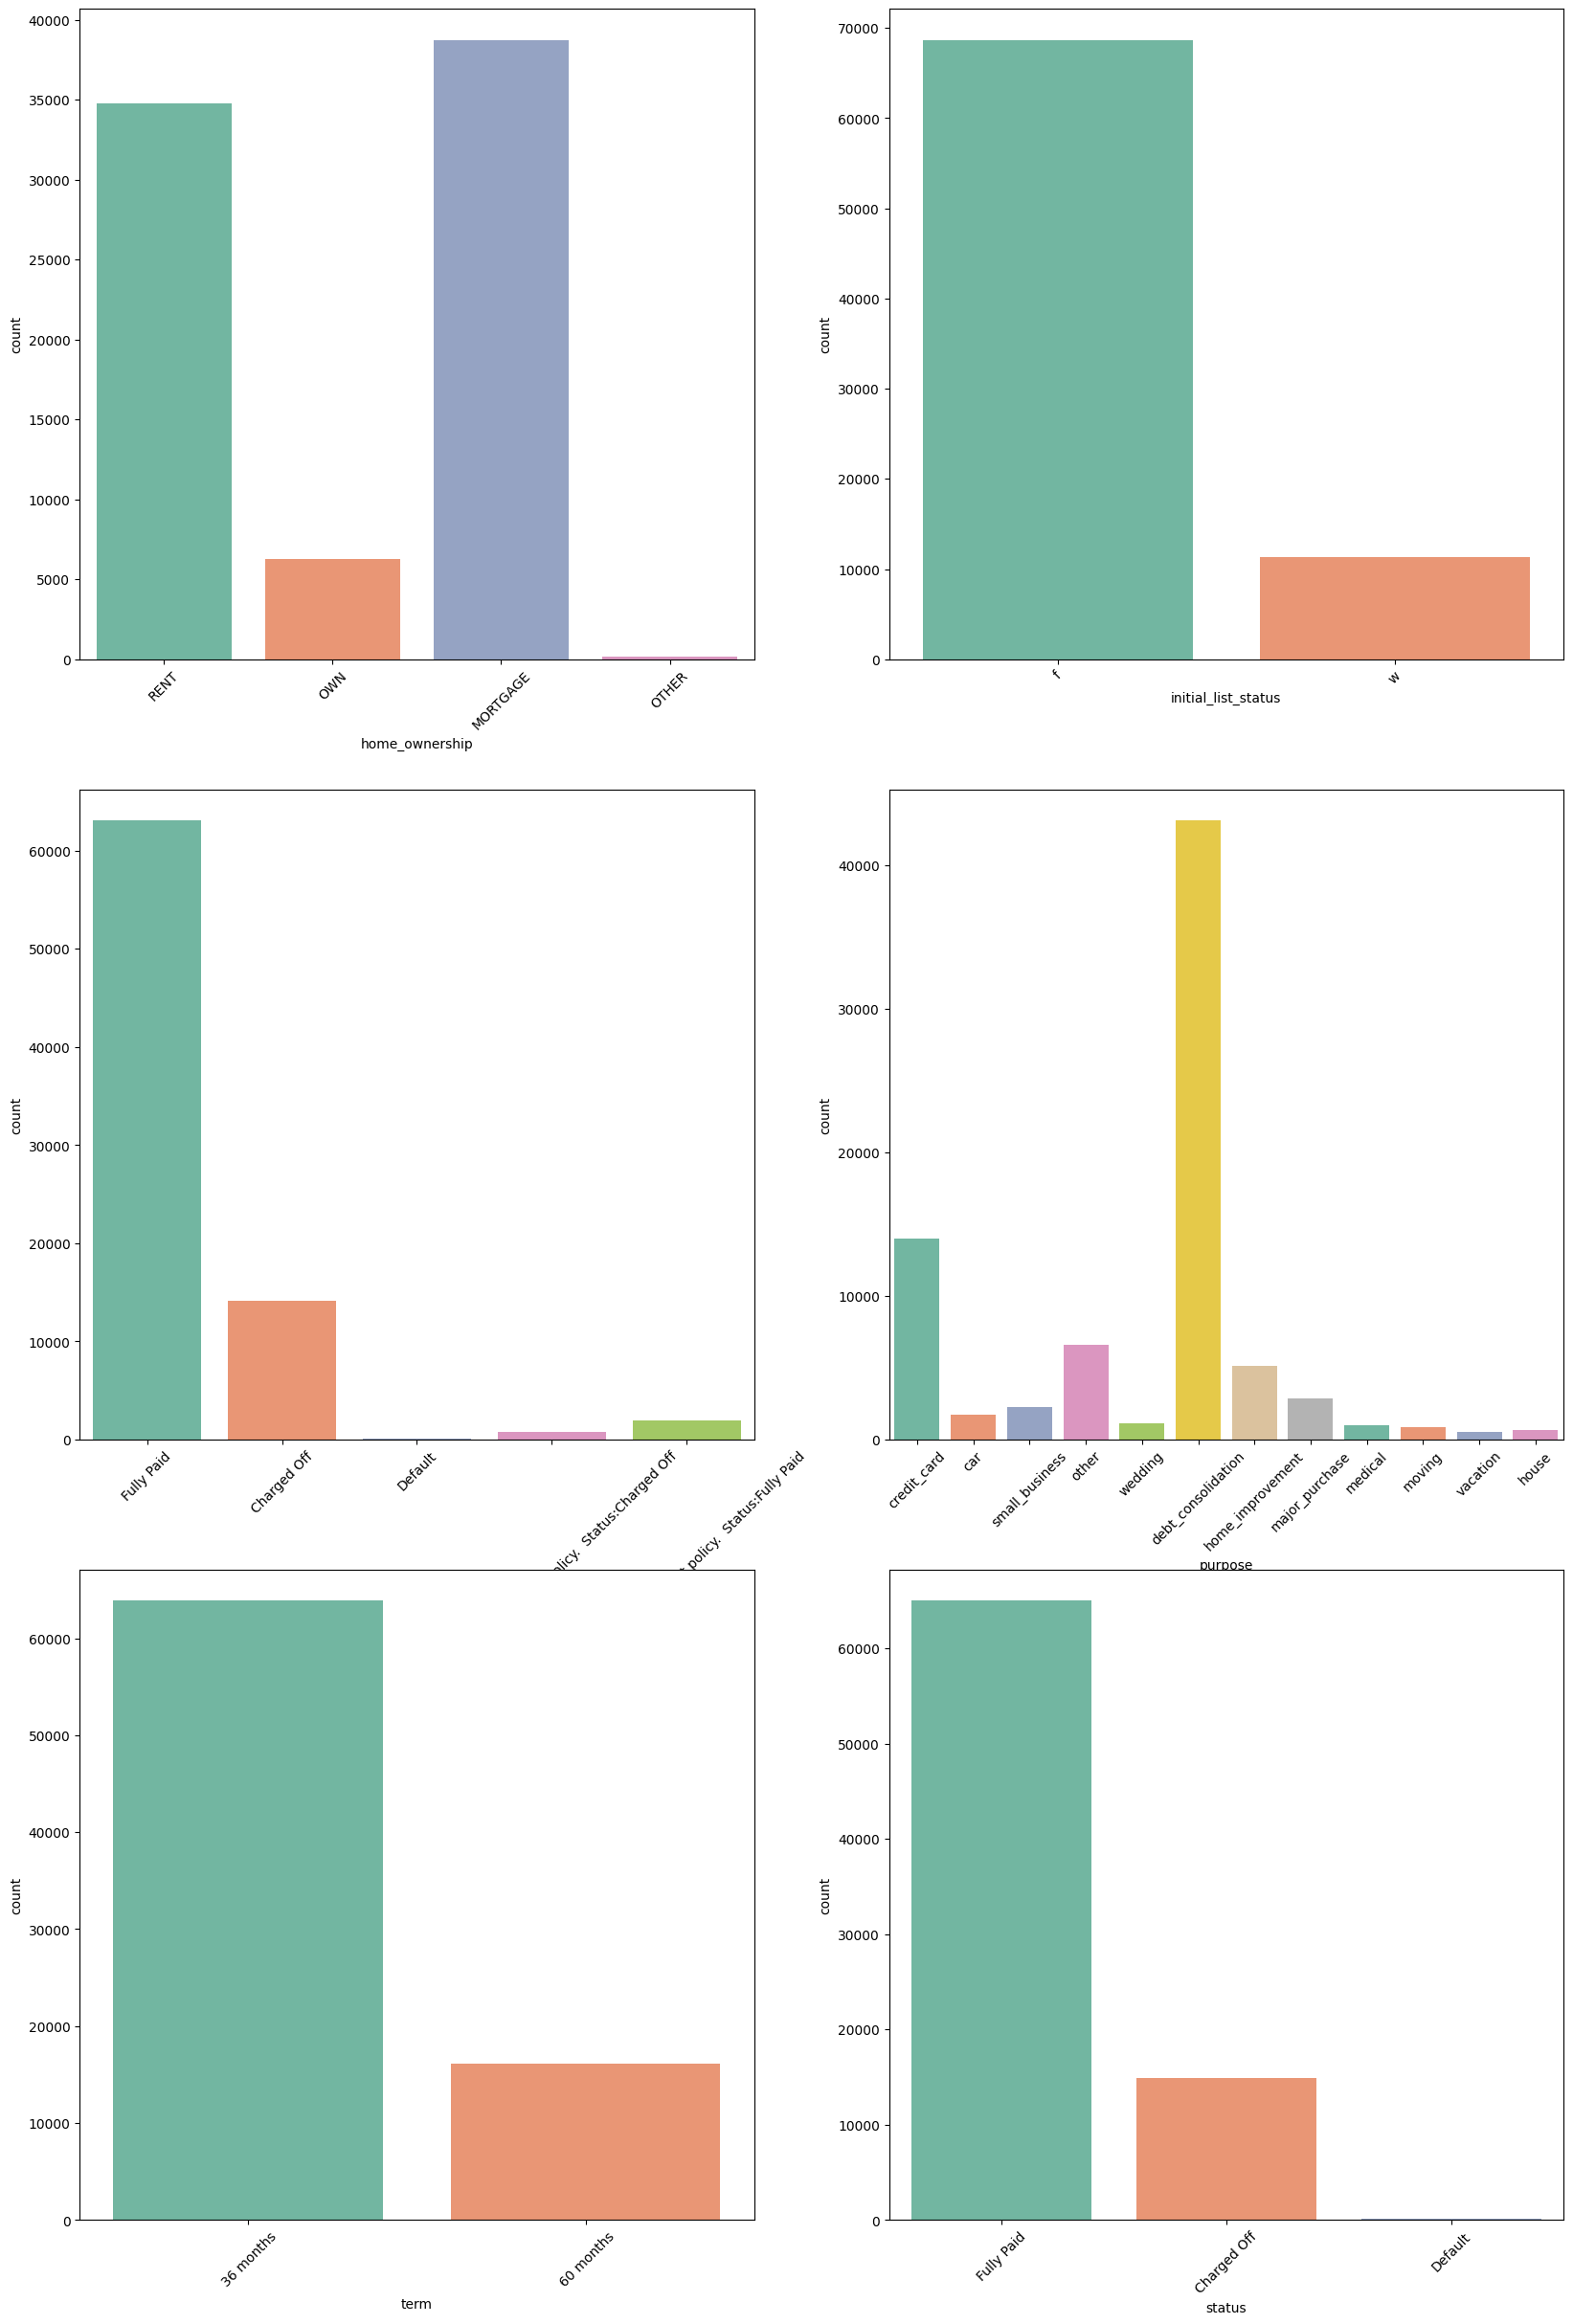

In [166]:
fig, axs = plt.subplots(3, 2, figsize=(20,30))
catdata = categorical_features.columns
for col, ax in zip(catdata, axs.ravel()):
    sns.countplot(x=col,data=df,palette='Set2',ax=ax)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

image_path = "first_graphic.png"

plt.savefig(image_path)

- Numerical Variables

In [167]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.head(2)

,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,pub_rec,recoveries,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,not_compliant,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
0,24000.0,0.00,0.0,0.0,27.65,5000,4975,1.0,162.87,10.65,171.62,5000,NaN,3.0,0.0,0.0,0.0,0.00,13648,83.7,9.0,5861.07,5831.78,861.07,0.0,0,0,11,5,0.4,8.1435,1
1,30000.0,1.11,0.0,0.0,1.00,2500,2500,5.0,59.83,15.27,119.66,2500,NaN,3.0,0.0,0.0,0.0,117.08,1687,9.4,4.0,1008.71,1008.71,435.17,0.0,0,1,1,4,0.8,2.3932,1


In [168]:
numerical_features.apply(lambda x : len(x.unique()))

annual_inc                      8375
collection_recovery_fee         4928
collections_12_mths_ex_med         4
delinq_2yrs                       17
dti                             3476
funded_amnt                     1149
funded_amnt_inv                 6813
inq_last_6mths                    29
installment                    25156
int_rate                         464
last_pymnt_amnt                69009
loan_amnt                       1107
mths_since_last_major_derog      104
open_acc                          52
out_prncp                        111
out_prncp_inv                    111
pub_rec                           10
recoveries                      7219
revol_bal                      31977
revol_util                      1144
total_acc                         86
total_pymnt                    73838
total_pymnt_inv                74129
total_rec_int                  70730
total_rec_late_fee              2022
not_compliant                      2
bad_loans                          2
e

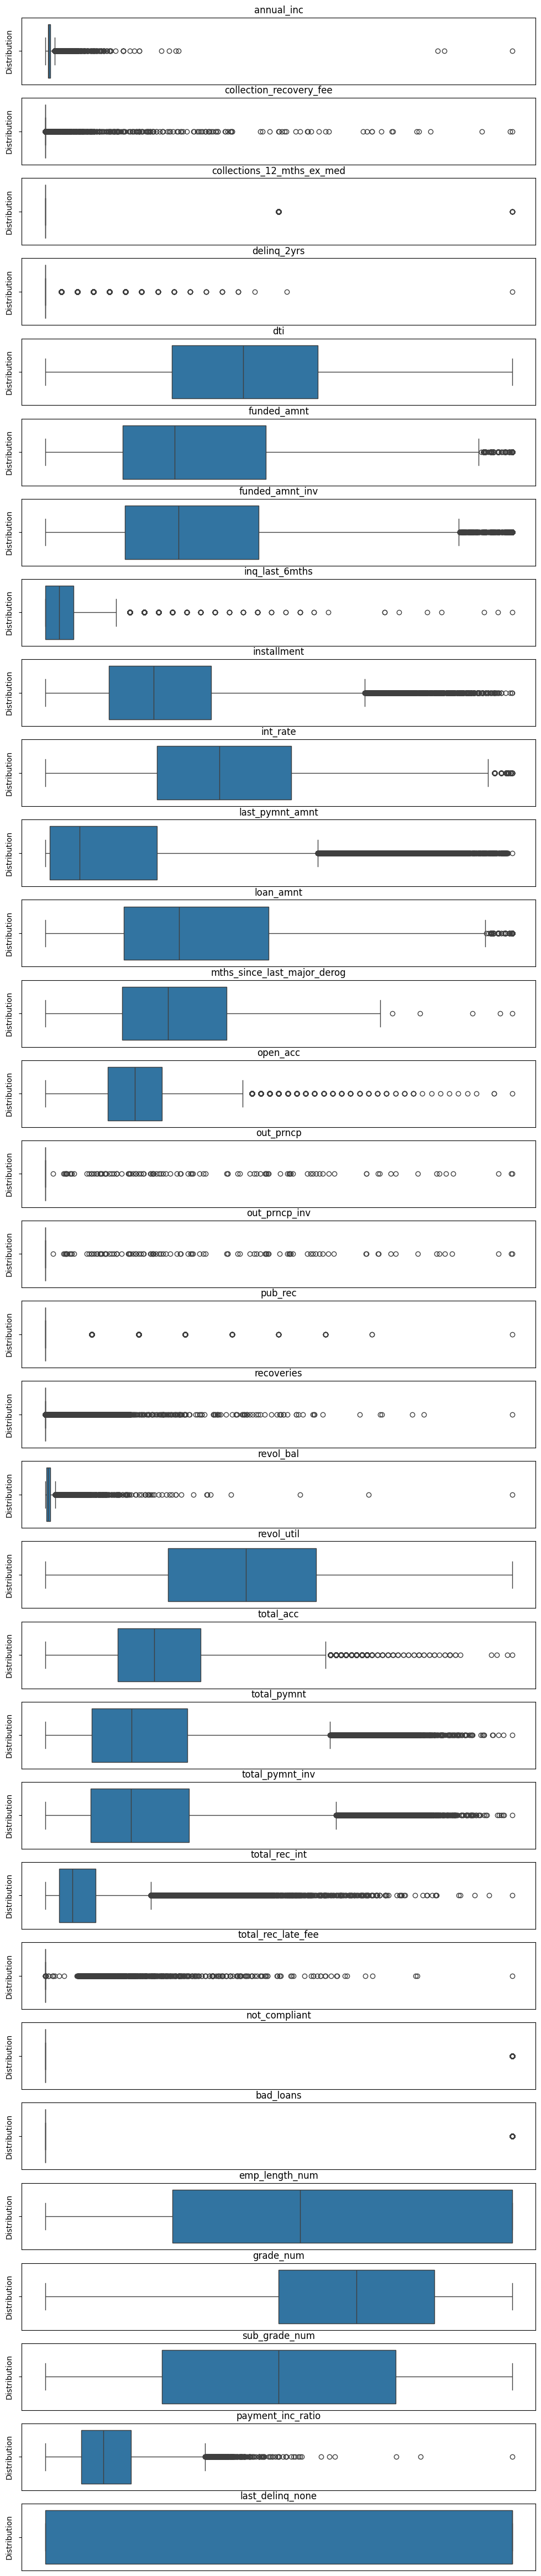

In [169]:
cols = numerical_features.columns
fig, axs = plt.subplots(len(cols),1,figsize=(12,60))

for col, ax in zip(cols, axs.ravel()):
  sns.boxplot(x=col, data=numerical_features, ax=ax)
  ax.set_ylabel("Distribution")
  ax.get_xaxis().set_visible(False)
  ax.set_title(col)

In [170]:
variable = df['collections_12_mths_ex_med']
variable.unique()

array([ 0., nan,  1.,  2.])

In [171]:
variable = df['delinq_2yrs']
variable.unique()

array([ 0.,  2.,  3.,  1.,  4.,  6.,  5.,  8.,  7.,  9., 11., nan, 13.,
       10., 15., 12., 29.])

In [172]:
correlacion_pearson = numerical_features.corr(method='pearson')
correlacion_pearson

,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,pub_rec,recoveries,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,not_compliant,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
annual_inc,1.000000,0.007423,0.007473,0.045637,-0.136117,0.285865,0.275348,0.044869,0.288236,0.001164,0.188674,0.287377,-0.097560,0.148148,0.001392,0.001392,-0.016823,0.022952,0.276338,0.024723,0.216572,0.271805,0.264797,0.181753,0.003255,-0.000320,-0.053146,0.107879,-0.003589,0.002757,-0.243942,-0.047556
collection_recovery_fee,0.007423,1.000000,-0.002256,0.004142,-0.003370,0.027710,0.015345,0.027450,0.032018,0.022640,-0.041845,0.028111,-0.013667,-0.005168,-0.001703,-0.001703,-0.005801,0.647493,0.007648,0.008344,-0.004142,0.002764,-0.007820,0.010427,0.081958,0.037248,0.117320,-0.005711,-0.042042,0.000169,0.026474,-0.010794
collections_12_mths_ex_med,0.007473,-0.002256,1.000000,0.030298,0.007736,0.007171,0.009217,-0.006019,0.012783,0.046710,0.018744,0.006436,-0.089237,0.016379,-0.001468,-0.001468,0.022580,0.000017,-0.001440,-0.007411,0.015995,0.007020,0.008900,0.003811,-0.003180,-0.008869,-0.000981,0.005207,-0.033926,0.001963,0.002423,-0.024820
delinq_2yrs,0.045637,0.004142,0.030298,1.000000,-0.006899,0.013492,0.013026,0.018539,0.025645,0.119927,0.027278,0.012095,-0.457369,0.050574,0.003757,0.003762,-0.014220,0.015026,-0.026483,-0.018610,0.112096,0.004101,0.003333,0.022628,0.015593,0.011284,0.016611,0.031105,-0.113433,-0.001902,-0.039204,-0.385806
dti,-0.136117,-0.003370,0.007736,-0.006899,1.000000,0.093661,0.105728,0.001108,0.096194,0.203816,0.066108,0.090171,0.048635,0.324385,0.014630,0.014636,-0.018356,0.042208,0.163936,0.272287,0.250915,0.025407,0.037137,0.079163,-0.024677,-0.021896,0.116723,0.067301,-0.145447,0.015741,0.226112,0.017859
funded_amnt,0.285865,0.027710,0.007171,0.013492,0.093661,1.000000,0.976209,-0.011205,0.963268,0.248331,0.591853,0.993300,-0.086017,0.220659,0.035877,0.035874,-0.050917,0.154704,0.278179,0.115005,0.256676,0.830232,0.817508,0.689502,0.012260,-0.085679,0.067068,0.163903,-0.201581,0.033304,0.542826,0.007658
funded_amnt_inv,0.275348,0.015345,0.009217,0.013026,0.105728,0.976209,1.000000,-0.038084,0.936891,0.253413,0.600904,0.968184,-0.085890,0.218521,0.036833,0.036831,-0.046299,0.147596,0.258252,0.121027,0.256044,0.812474,0.838887,0.667216,-0.008882,-0.139536,0.057027,0.173610,-0.180557,0.031775,0.524703,0.022802
inq_last_6mths,0.044869,0.027450,-0.006019,0.018539,0.001108,-0.011205,-0.038084,1.000000,0.003604,0.184540,-0.026088,-0.010544,-0.008176,0.099488,-0.006145,-0.006142,0.022145,0.034425,0.011971,-0.069293,0.111226,-0.030631,-0.050639,0.035752,0.055773,0.433491,0.078397,-0.018561,-0.232039,0.023577,-0.052018,-0.051815
installment,0.288236,0.032018,0.012783,0.025645,0.096194,0.963268,0.936891,0.003604,1.000000,0.239376,0.546947,0.953595,-0.080786,0.219518,0.031933,0.031933,-0.039447,0.143663,0.279237,0.143669,0.241785,0.810067,0.794928,0.638529,0.018699,-0.072087,0.050098,0.149004,-0.189685,0.025081,0.579221,-0.011877
int_rate,0.001164,0.022640,0.046710,0.119927,0.203816,0.248331,0.253413,0.184540,0.239376,1.000000,0.187481,0.243295,-0.001089,0.058176,0.030013,0.030016,0.098865,0.144946,0.035655,0.405590,-0.000463,0.130698,0.137782,0.386164,0.031918,0.026591,0.244784,0.042570,-0.920855,0.038010,0.222730,-0.173128


In [173]:
umbral = 0.5
columnas_altamente_correlacionadas = set()

for i in range(len(correlacion_pearson.columns)):
    for j in range(i):
        if abs(correlacion_pearson.iloc[i, j]) > umbral:
            colname = correlacion_pearson.columns[i]
            columnas_altamente_correlacionadas.add(colname)

In [174]:
columnas_altamente_correlacionadas

{'funded_amnt_inv',
 'grade_num',
 'installment',
 'last_pymnt_amnt',
 'loan_amnt',
 'out_prncp_inv',
 'payment_inc_ratio',
 'recoveries',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int'}

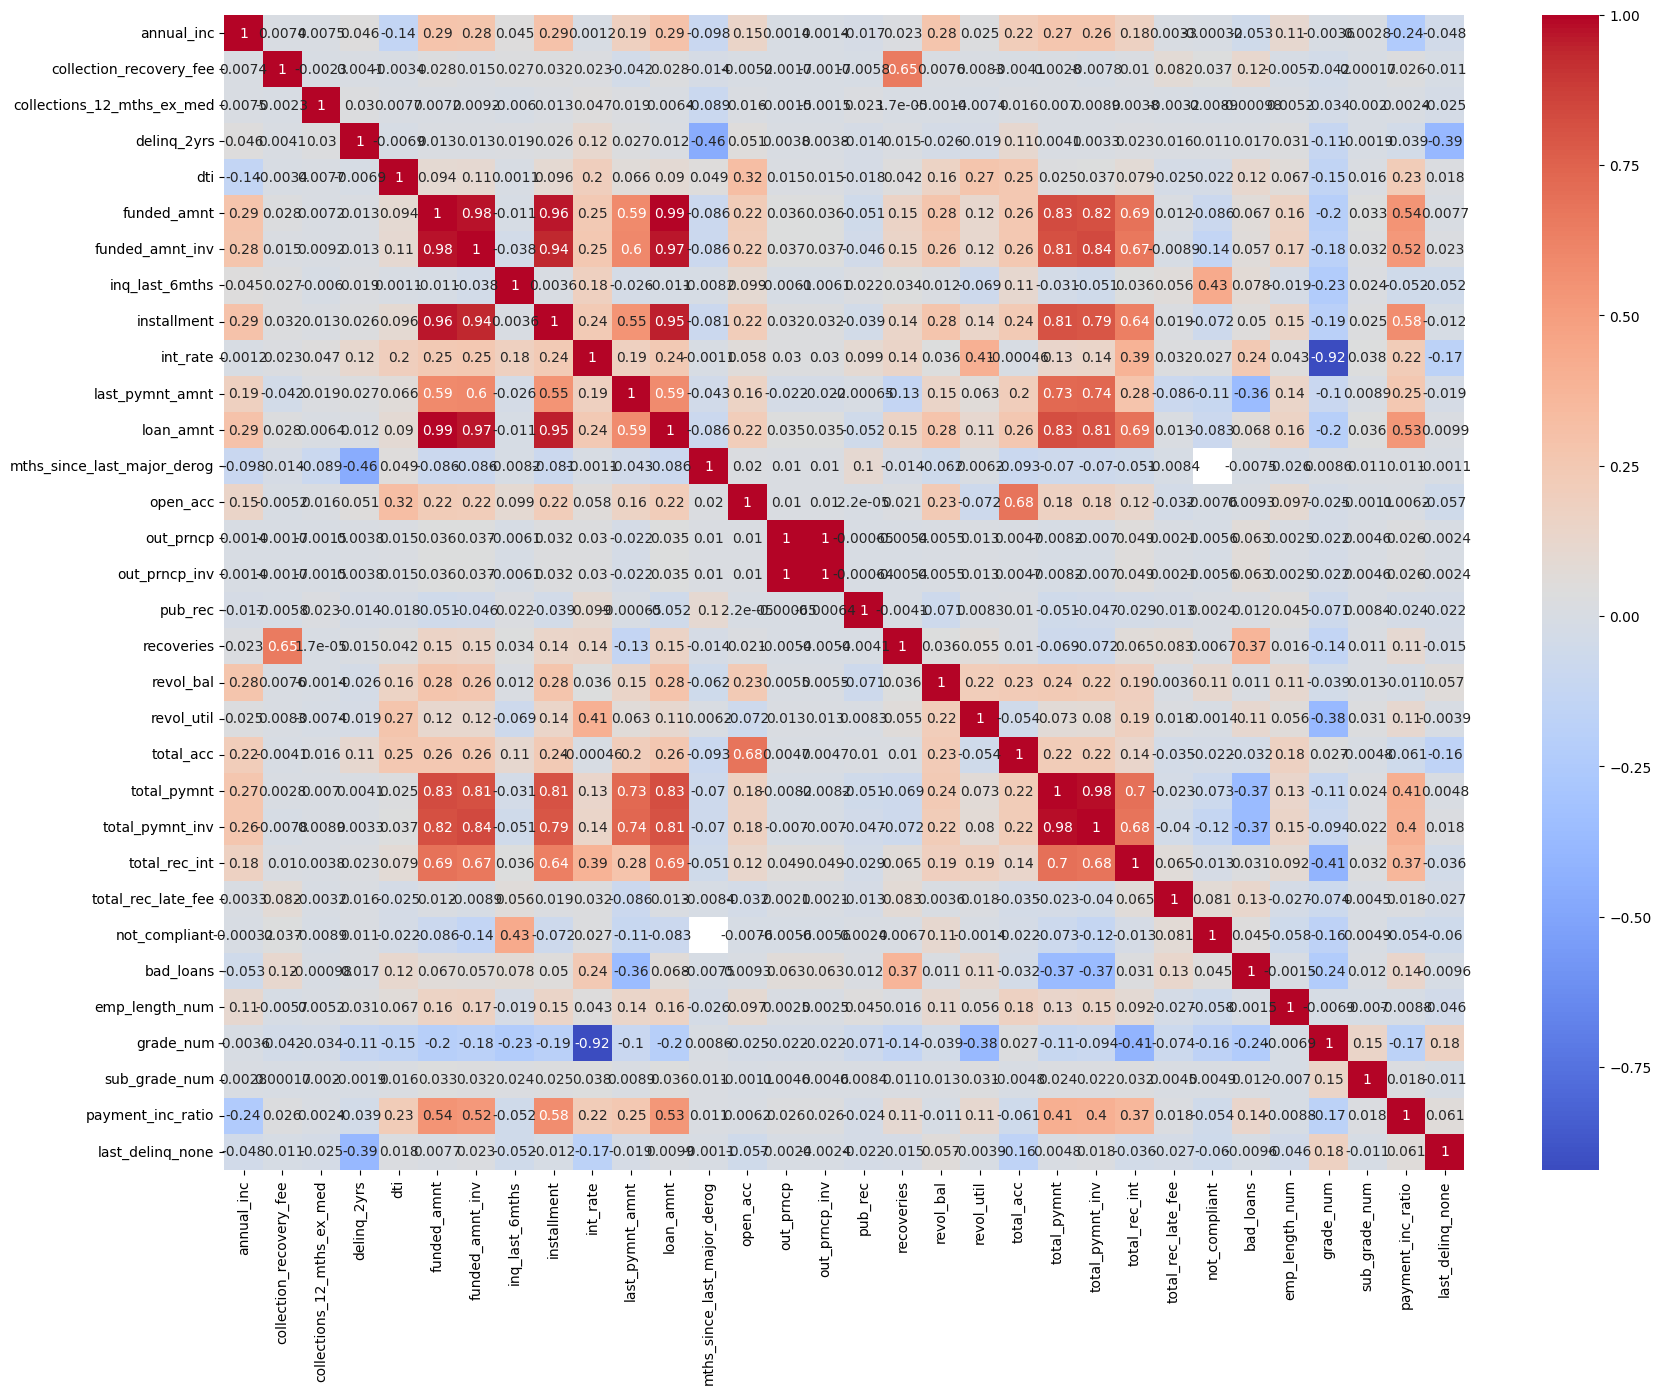

In [175]:
matriz_correlacion = numerical_features.corr()
plt.figure(figsize=(20, 15))

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.show()

In [176]:
pd.set_option('display.max_columns', 32)

numerical_features.describe(include='all')

,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,pub_rec,recoveries,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,not_compliant,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
count,7.999600e+04,80000.000000,79855.000000,79971.000000,80000.000000,80000.000000,80000.000000,79971.000000,80000.000000,80000.000000,80000.000000,80000.000000,8881.000000,79971.000000,80000.000000,80000.000000,79971.000000,80000.000000,8.000000e+04,80000.000000,79971.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,79996.000000,80000.000000
mean,7.135391e+04,6.364264,0.002580,0.203486,15.064076,12400.805313,12045.176675,1.012605,385.442230,13.467045,5534.186971,12509.563438,41.671884,10.253892,14.904362,14.897442,0.097923,110.600221,1.509356e+04,53.174428,23.904140,12283.940359,11923.063503,1751.805897,0.890305,0.03335,0.187512,6.264950,4.238300,0.599420,7.375736,0.590562
std,6.393560e+04,112.920560,0.053137,0.632788,7.420169,7769.497087,7850.350561,1.347200,235.886562,4.355803,6787.355356,7839.056266,21.199773,4.669080,493.389783,493.139121,0.342558,616.071083,2.137312e+04,26.216695,11.657301,8895.934934,8914.645337,1741.198613,5.875062,0.17955,0.390325,3.730245,1.371062,0.278316,4.087201,0.491733
min,1.896000e+03,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000,15.670000,5.420000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.200000,0.028895,0.000000
25%,4.400000e+04,0.000000,0.000000,0.000000,9.500000,6250.000000,6000.000000,0.000000,205.280000,10.370000,360.867500,6300.000000,25.000000,7.000000,0.000000,0.000000,0.000000,0.000000,5.220000e+03,33.700000,15.000000,5583.770000,5262.290000,622.270000,0.000000,0.00000,0.000000,3.000000,3.000000,0.400000,4.216670,0.000000
50%,6.000000e+04,0.000000,0.000000,0.000000,14.830000,10050.000000,10000.000000,1.000000,338.930000,13.110000,2683.065000,10375.000000,40.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.041600e+04,55.100000,22.000000,10303.800000,9922.765000,1212.595000,0.000000,0.00000,0.000000,6.000000,4.000000,0.600000,6.763780,1.000000
75%,8.500000e+04,0.000000,0.000000,0.000000,20.410000,16800.000000,16000.000000,2.000000,510.660000,16.290000,8643.932500,17000.000000,59.000000,13.000000,0.000000,0.000000,0.000000,0.000000,1.865425e+04,74.300000,31.000000,16954.625000,16595.925000,2250.487500,0.000000,0.00000,0.000000,11.000000,5.000000,0.800000,9.963000,1.000000
max,7.141778e+06,7002.190000,2.000000,29.000000,34.990000,35000.000000,35000.000000,33.000000,1408.130000,26.060000,36115.200000,35000.000000,152.000000,52.000000,31503.400000,31503.400000,10.000000,27750.000000,1.743266e+06,128.100000,91.000000,55758.200000,53913.900000,20758.200000,208.820000,1.00000,1.000000,11.000000,6.000000,1.000000,54.171000,1.000000


**I remove columns that have constant data,** 75% of the instances are the same:

--> collection_recovery_fee,	collections_12_mths_ex_med,	delinq_2yrs,
out_prncp,	out_prncp_inv,	pub_rec,	recoveries, total_rec_late_fee,
not_compliant, last_delinq_none


In [177]:
drop_columns = ['collection_recovery_fee',	'collections_12_mths_ex_med',	'delinq_2yrs',
'out_prncp',	'out_prncp_inv',	'pub_rec',	'recoveries', 'total_rec_late_fee', 'not_compliant', 'last_delinq_none']
numerical_features = numerical_features.drop(drop_columns, axis=1)

## **Final DataFrame**

FINAL VARIABLES (28)

In [178]:
df = pd.concat([categorical_features, numerical_features], axis=1)
df.head()

,home_ownership,initial_list_status,loan_status,purpose,term,status,annual_inc,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,mths_since_last_major_derog,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio
0,RENT,f,Fully Paid,credit_card,36 months,Fully Paid,24000.0,27.65,5000,4975,1.0,162.87,10.65,171.62,5000,NaN,3.0,13648,83.7,9.0,5861.07,5831.78,861.07,0,11,5,0.4,8.14350
1,RENT,f,Charged Off,car,60 months,Charged Off,30000.0,1.00,2500,2500,5.0,59.83,15.27,119.66,2500,NaN,3.0,1687,9.4,4.0,1008.71,1008.71,435.17,1,1,4,0.8,2.39320
2,RENT,f,Fully Paid,small_business,36 months,Fully Paid,12252.0,8.72,2400,2400,2.0,84.33,15.96,649.91,2400,NaN,2.0,2956,98.5,10.0,3003.65,3003.65,603.65,0,11,4,1.0,8.25955
3,RENT,f,Fully Paid,other,36 months,Fully Paid,49200.0,20.00,10000,10000,1.0,339.31,13.49,357.48,10000,NaN,10.0,5598,21.0,37.0,12226.30,12226.30,2209.33,0,11,4,0.2,8.27585
4,RENT,f,Fully Paid,wedding,36 months,Fully Paid,36000.0,11.20,5000,5000,3.0,156.46,7.90,161.03,5000,NaN,9.0,7963,28.3,12.0,5631.38,5631.38,631.38,0,4,6,0.8,5.21533


## **Analyse the Target (bad_loans)**

[Text(0, 0, '0'), Text(1, 0, '1')]

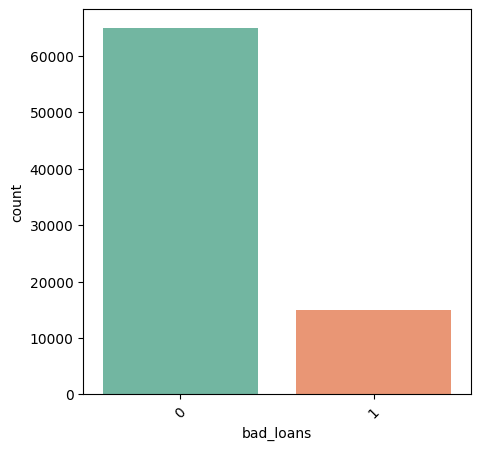

In [179]:
target="bad_loans"

fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(x=target,data=df,palette='Set2',ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

We have a very unbalanced dependent variable, as there are many cases of safe loans and very few risky loans. The model would learn very well only to identify safe loans. It is more important to know how to identify the risky loans that would generate defaults.

To solve this, it is necessary to balance the dataset, reducing the number of instances of safe credit to equal the number of instances of risky credit.

Another option would be to create synthetic data by replicating instances that are type 1.

## **First Modelling**

### Target Balancing (bad_loans)

In [180]:
creditos_seguros = df[df[target] == 0]
creditos_riesgo = df[df[target] == 1]

print('Safe Loans:', len(creditos_seguros))
print('Risk Loans:', len(creditos_riesgo))

Safe Loans: 64999
Risk Loans: 15001


In [181]:
#Submuestreo la clase más numerosa

porcentaje = len(creditos_riesgo)/(len(creditos_seguros))
riesgo = creditos_riesgo

#Array aleatorio de valores entre 0 y 1

msk = np.random.rand(len(creditos_seguros)) < porcentaje #reducimos la cantidad de creditos seguros
seguros = creditos_seguros[msk] #filtro con la mascara

print('Percentage of risky credit variables with respect to secured credit:', porcentaje*100, '%')
print('New number of safe credit variables:', len(seguros))
print('Risk Loans:', len(riesgo))

Percentage of risky credit variables with respect to secured credit: 23.078816597178417 %
New number of safe credit variables: 14818
Risk Loans: 15001


In [182]:
pip install pandas==1.5.3

Note: you may need to restart the kernel to use updated packages.


In [183]:
df = riesgo.append(seguros)

print('Percentage of safe loans:', round(100*(len(seguros)/(len(df))),3))
print('Percentage of risk loans:', round(100*(len(riesgo)/(len(df))),3))
print('Total number of loans:', len(df))

Percentage of safe loans: 49.693
Percentage of risk loans: 50.307
Total number of loans: 29819


[Text(0, 0, '0'), Text(1, 0, '1')]

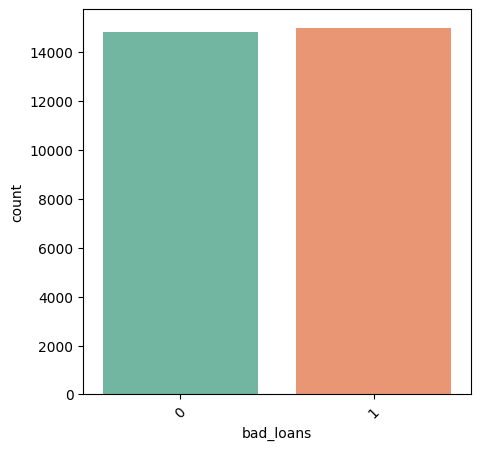

In [184]:
target="bad_loans"

fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(x=target,data=df,palette='Set2',ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [185]:
inspect_data(df)

Data Shape

(29819, 28)




Missing Values: 

home_ownership                     0
initial_list_status                0
loan_status                        0
purpose                            0
term                               0
status                             0
annual_inc                         1
dti                                0
funded_amnt                        0
funded_amnt_inv                    0
inq_last_6mths                     7
installment                        0
int_rate                           0
last_pymnt_amnt                    0
loan_amnt                          0
mths_since_last_major_derog    26365
open_acc                           7
revol_bal                          0
revol_util                         0
total_acc                          7
total_pymnt                        0
total_pymnt_inv                    0
total_rec_int                      0
bad_loans                          0
emp_length_num                     0
grade_num                          0
sub_grade_num                      0
p

Data Types: 

home_ownership                  object
initial_list_status             object
loan_status                     object
purpose                         object
term                            object
status                          object
annual_inc                     float64
dti                            float64
funded_amnt                      int64
funded_amnt_inv                  int64
inq_last_6mths                 float64
installment                    float64
int_rate                       float64
last_pymnt_amnt                float64
loan_amnt                        int64
mths_since_last_major_derog    float64
open_acc                       float64
revol_bal                        int64
revol_util                     float64
total_acc                      float64
total_pymnt                    float64
total_pymnt_inv                float64
total_rec_int                  float64
bad_loans                        int64
emp_length_num                   int64
grade_num                

### Null data


In [186]:
df.isnull().sum()

home_ownership                     0
initial_list_status                0
loan_status                        0
purpose                            0
term                               0
status                             0
annual_inc                         1
dti                                0
funded_amnt                        0
funded_amnt_inv                    0
inq_last_6mths                     7
installment                        0
int_rate                           0
last_pymnt_amnt                    0
loan_amnt                          0
mths_since_last_major_derog    26365
open_acc                           7
revol_bal                          0
revol_util                         0
total_acc                          7
total_pymnt                        0
total_pymnt_inv                    0
total_rec_int                      0
bad_loans                          0
emp_length_num                     0
grade_num                          0
sub_grade_num                      0
p

In [187]:
len(df)

29819

The mths_since_last_major_derog column has most of its values null, so **is removed**

In [188]:
df = df.drop('mths_since_last_major_derog', axis=1)

In [189]:
df.isnull().sum()

home_ownership         0
initial_list_status    0
loan_status            0
purpose                0
term                   0
status                 0
annual_inc             1
dti                    0
funded_amnt            0
funded_amnt_inv        0
inq_last_6mths         7
installment            0
int_rate               0
last_pymnt_amnt        0
loan_amnt              0
open_acc               7
revol_bal              0
revol_util             0
total_acc              7
total_pymnt            0
total_pymnt_inv        0
total_rec_int          0
bad_loans              0
emp_length_num         0
grade_num              0
sub_grade_num          0
payment_inc_ratio      1
dtype: int64

There are not many null values, so I eliminate them with the average value of the column

In [190]:
mostCommonValueImputation(df, 'annual_inc')
mostCommonValueImputation(df, 'inq_last_6mths')
mostCommonValueImputation(df, 'open_acc')
mostCommonValueImputation(df, 'total_acc')
mostCommonValueImputation(df, 'payment_inc_ratio')

### Outliers

We use the density-based method **LocalOutlierFactor**

In [191]:
data_clean = df.copy()

In [192]:
numerical_features = data_clean.select_dtypes(include=[np.number])
data_clean = modelOutlierDetection(data_clean, numerical_features, n = 1000, drop = False)

Se han eliminado : 957 instancias.


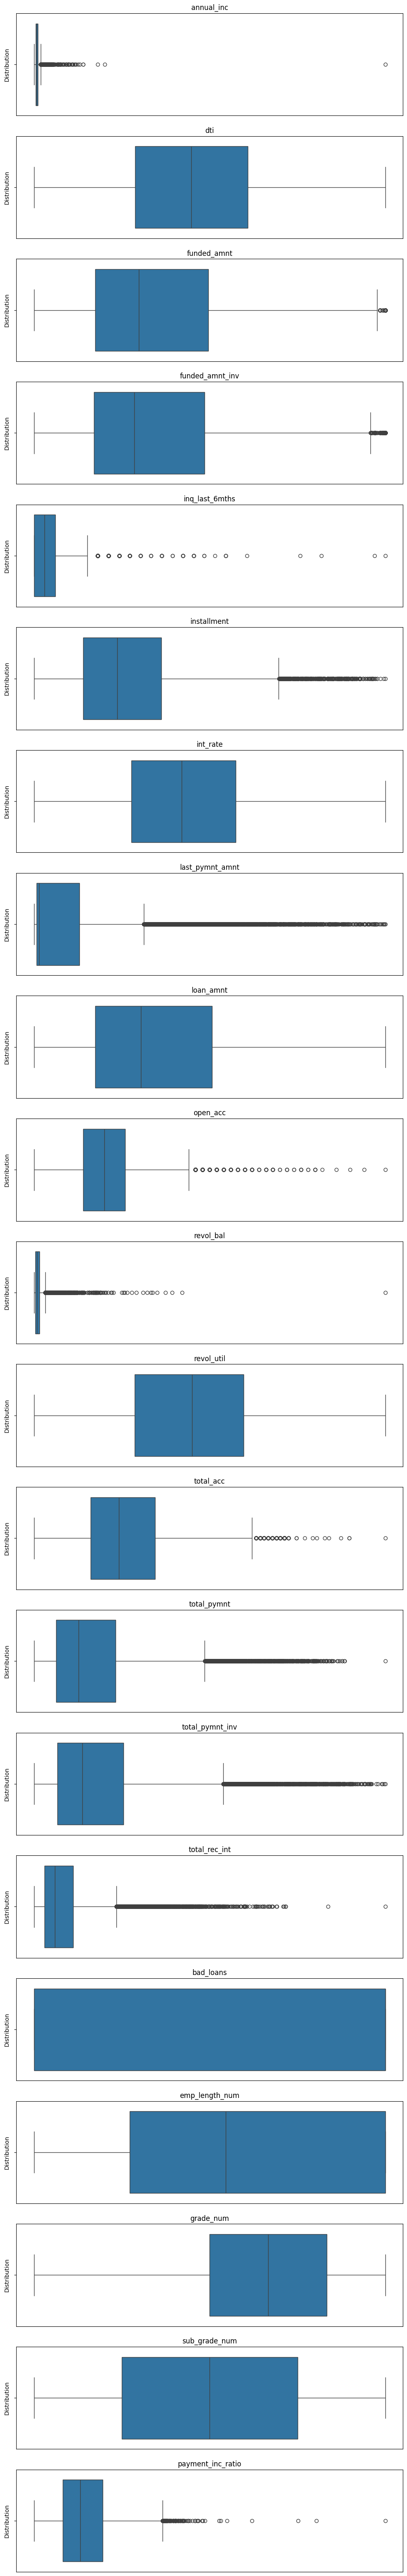

In [193]:
cols = numerical_features.columns
fig, axs = plt.subplots(len(cols),1,figsize=(12,80))

for col, ax in zip(cols, axs.ravel()):
  sns.boxplot(x=col, data=numerical_features, ax=ax)
  ax.set_ylabel("Distribution")
  ax.get_xaxis().set_visible(False)
  ax.set_title(col)

### Encoding

The most appropriate coding is that which does not create too many new **variables (Dimensions)**

In [194]:
data_clean.dtypes

home_ownership          object
initial_list_status     object
loan_status             object
purpose                 object
term                    object
status                  object
annual_inc             float64
dti                    float64
funded_amnt              int64
funded_amnt_inv          int64
inq_last_6mths         float64
installment            float64
int_rate               float64
last_pymnt_amnt        float64
loan_amnt                int64
open_acc               float64
revol_bal                int64
revol_util             float64
total_acc              float64
total_pymnt            float64
total_pymnt_inv        float64
total_rec_int          float64
bad_loans                int64
emp_length_num           int64
grade_num                int64
sub_grade_num          float64
payment_inc_ratio      float64
dtype: object

In [195]:
categorical_features = data_clean.select_dtypes(include=[object])

In [196]:
#data_cod = binaryEncoding(data_clean, categorical_features)

In [197]:
data_cod = labelEncoding(data_clean, categorical_features)

In [198]:
data_cod.head()

,annual_inc,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,home_ownership_cod,initial_list_status_cod,loan_status_cod,purpose_cod,term_cod,status_cod
1,30000.0,1.00,2500,2500,5.0,59.83,15.27,119.66,2500,3.0,1687,9.4,4.0,1008.71,1008.71,435.17,1,1,4,0.8,2.39320,3,0,0,0,1,0
6,40000.0,5.55,5600,5600,2.0,152.39,21.28,152.39,5600,11.0,5210,32.6,13.0,646.02,646.02,294.94,1,5,1,0.4,4.57170,2,0,0,9,1,0
7,15000.0,18.08,5375,5350,0.0,121.45,12.69,121.45,5375,2.0,9279,36.5,3.0,1476.19,1469.34,533.42,1,1,5,1.0,9.71600,3,0,0,8,1,0
10,30000.0,10.08,9000,9000,1.0,305.38,13.49,305.38,9000,4.0,10452,91.7,9.0,2270.70,2270.70,570.26,1,1,4,0.2,12.21520,3,0,0,2,0,0
12,100000.0,7.06,10000,10000,2.0,325.74,10.65,325.74,10000,14.0,11997,55.5,29.0,7471.99,7471.99,1393.42,1,4,5,0.4,3.90888,3,0,0,8,0,0


In [199]:
data_cod.dtypes

annual_inc                 float64
dti                        float64
funded_amnt                  int64
funded_amnt_inv              int64
inq_last_6mths             float64
installment                float64
int_rate                   float64
last_pymnt_amnt            float64
loan_amnt                    int64
open_acc                   float64
revol_bal                    int64
revol_util                 float64
total_acc                  float64
total_pymnt                float64
total_pymnt_inv            float64
total_rec_int              float64
bad_loans                    int64
emp_length_num               int64
grade_num                    int64
sub_grade_num              float64
payment_inc_ratio          float64
home_ownership_cod           int64
initial_list_status_cod      int64
loan_status_cod              int64
purpose_cod                  int64
term_cod                     int64
status_cod                   int64
dtype: object

### Scaler

In [200]:
std_scaler = StandardScaler()
inf = {}
for i in data_cod.columns:
  if i == "bad_loans": #no quiero escalar la variable dependiente
    inf[i+"scl"] = np.array(data_cod[i])
  else:
    inf[i+"scl"] = std_scaler.fit_transform(data_cod[[i]]).reshape(-1)

data_scl = pd.DataFrame(inf)

data_scl.head()

,annual_incscl,dtiscl,funded_amntscl,funded_amnt_invscl,inq_last_6mthsscl,installmentscl,int_ratescl,last_pymnt_amntscl,loan_amntscl,open_accscl,revol_balscl,revol_utilscl,total_accscl,total_pymntscl,total_pymnt_invscl,total_rec_intscl,bad_loansscl,emp_length_numscl,grade_numscl,sub_grade_numscl,payment_inc_ratioscl,home_ownership_codscl,initial_list_status_codscl,loan_status_codscl,purpose_codscl,term_codscl,status_codscl
0,-0.618073,-1.944336,-1.288761,-1.221549,2.746080,-1.394383,0.218364,-0.582072,-1.290857,-1.549084,-0.660492,-1.780804,-1.696200,-1.044983,-1.009537,-0.761896,1,-1.405865,0.010792,0.712393,-1.277129,1.032953,-0.411382,-1.034188,-1.191017,1.706675,-0.9994
1,-0.458085,-1.345121,-0.899372,-0.836900,0.641004,-1.007020,1.567526,-0.576415,-0.905402,0.154920,-0.488091,-0.884338,-0.916803,-1.089431,-1.054153,-0.840771,1,-0.340218,-2.087867,-0.726483,-0.762782,0.340533,-0.411382,-1.034188,2.338709,1.706675,-0.9994
2,-0.858055,0.305026,-0.927634,-0.867920,-0.762380,-1.136503,-0.360810,-0.581763,-0.933379,-1.762085,-0.288971,-0.733639,-1.782800,-0.987692,-0.952872,-0.706634,1,-1.405865,0.710345,1.431831,0.451797,1.032953,-0.411382,-1.034188,1.946517,1.706675,-0.9994
3,-0.618073,-0.748539,-0.472301,-0.415026,-0.060688,-0.366757,-0.181221,-0.549970,-0.482646,-1.336084,-0.231569,1.399334,-1.263202,-0.890324,-0.854293,-0.685913,1,-1.405865,0.010792,-1.445921,1.041863,1.032953,-0.411382,-1.034188,-0.406633,-0.585934,-0.9994
4,0.501843,-1.146260,-0.346691,-0.290946,0.641004,-0.281550,-0.818761,-0.546451,-0.358306,0.793921,-0.155963,0.000537,0.468793,-0.252895,-0.214456,-0.222914,1,-0.606630,0.710345,-0.726483,-0.919275,1.032953,-0.411382,-1.034188,1.946517,-0.585934,-0.9994


**The mean should be 0** as the StandardScaler scales the data so that all data have mean 0, and the maximum and minimum are at the standard deviation of each of the values

In [201]:
data_scl.describe()

,annual_incscl,dtiscl,funded_amntscl,funded_amnt_invscl,inq_last_6mthsscl,installmentscl,int_ratescl,last_pymnt_amntscl,loan_amntscl,open_accscl,revol_balscl,revol_utilscl,total_accscl,total_pymntscl,total_pymnt_invscl,total_rec_intscl,bad_loansscl,emp_length_numscl,grade_numscl,sub_grade_numscl,payment_inc_ratioscl,home_ownership_codscl,initial_list_status_codscl,loan_status_codscl,purpose_codscl,term_codscl,status_codscl
count,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,29819.000000,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,2.981900e+04,29819.000000,2.981900e+04,2.981900e+04
mean,3.812564e-17,-4.193820e-17,-1.067518e-16,3.812564e-17,1.143769e-17,-2.287538e-17,2.649732e-16,-9.150153e-17,-4.575076e-17,-1.258146e-16,3.431307e-17,-1.620340e-16,8.387640e-17,7.625127e-17,9.150153e-17,-9.054839e-17,0.503069,6.481358e-17,-1.525025e-17,1.934876e-16,2.397149e-16,-9.150153e-17,5.337589e-17,-1.830031e-16,0.000000,-1.906282e-17,1.220020e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.499999,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017,1.000017e+00,1.000017e+00
min,-1.067703e+00,-2.076031e+00,-1.539980e+00,-1.531750e+00,-7.623805e-01,-1.578188e+00,-1.992823e+00,-6.027556e-01,-1.539537e+00,-2.188086e+00,-7.430467e-01,-2.144028e+00,-1.955999e+00,-1.168602e+00,-1.133623e+00,-1.006664e+00,0.000000,-1.672277e+00,-2.787420e+00,-1.445921e+00,-1.830625e+00,-1.044308e+00,-4.113818e-01,-1.034188e+00,-1.191017,-5.859345e-01,-9.994000e-01
25%,-4.260874e-01,-7.485393e-01,-7.863239e-01,-7.872677e-01,-7.623805e-01,-7.616532e-01,-7.087631e-01,-5.580857e-01,-7.934964e-01,-6.970822e-01,-4.785483e-01,-7.220464e-01,-7.436034e-01,-7.341102e-01,-7.309852e-01,-6.589961e-01,0.000000,-8.730416e-01,-6.887614e-01,-7.264829e-01,-7.787314e-01,-1.044308e+00,-4.113818e-01,-1.034188e+00,-0.406633,-5.859345e-01,-9.994000e-01
50%,-1.381091e-01,-1.236077e-02,-2.462039e-01,-2.909459e-01,-6.068829e-02,-1.969295e-01,-4.652920e-02,-5.083634e-01,-2.339663e-01,-5.808066e-02,-2.225159e-01,8.554632e-02,-1.374054e-01,-3.019197e-01,-3.007940e-01,-3.137972e-01,1.000000,-7.380623e-02,1.079159e-02,-7.045034e-03,-1.386982e-01,3.405326e-01,-4.113818e-01,-1.389182e-02,-0.406633,-5.859345e-01,2.452639e-03
75%,2.138004e-01,7.277687e-01,6.110797e-01,5.776173e-01,6.410039e-01,5.359265e-01,6.673365e-01,1.949054e-01,6.364139e-01,5.809209e-01,1.766051e-01,8.119934e-01,6.419920e-01,4.207620e-01,4.144538e-01,2.988875e-01,1.000000,1.258253e+00,7.103445e-01,7.123928e-01,6.707109e-01,1.032953e+00,-4.113818e-01,1.006404e+00,-0.014441,1.706675e+00,1.004305e+00
max,1.131618e+02,2.531999e+00,2.793541e+00,2.811066e+00,2.239346e+01,4.248250e+00,2.640569e+00,5.565123e+00,2.750194e+00,8.461939e+00,5.834012e+01,2.805859e+00,5.578175e+00,5.664675e+00,4.929778e+00,1.066910e+01,1.000000,1.258253e+00,1.409898e+00,1.431831e+00,1.094771e+01,1.032953e+00,2.430832e+00,1.006404e+00,3.123093,1.706675e+00,1.004305e+00


### -------------------

### Data Partitioning

In [202]:
data_scl.head(2) #dataframe final

,annual_incscl,dtiscl,funded_amntscl,funded_amnt_invscl,inq_last_6mthsscl,installmentscl,int_ratescl,last_pymnt_amntscl,loan_amntscl,open_accscl,revol_balscl,revol_utilscl,total_accscl,total_pymntscl,total_pymnt_invscl,total_rec_intscl,bad_loansscl,emp_length_numscl,grade_numscl,sub_grade_numscl,payment_inc_ratioscl,home_ownership_codscl,initial_list_status_codscl,loan_status_codscl,purpose_codscl,term_codscl,status_codscl
0,-0.618073,-1.944336,-1.288761,-1.221549,2.746080,-1.394383,0.218364,-0.582072,-1.290857,-1.549084,-0.660492,-1.780804,-1.696200,-1.044983,-1.009537,-0.761896,1,-1.405865,0.010792,0.712393,-1.277129,1.032953,-0.411382,-1.034188,-1.191017,1.706675,-0.9994
1,-0.458085,-1.345121,-0.899372,-0.836900,0.641004,-1.007020,1.567526,-0.576415,-0.905402,0.154920,-0.488091,-0.884338,-0.916803,-1.089431,-1.054153,-0.840771,1,-0.340218,-2.087867,-0.726483,-0.762782,0.340533,-0.411382,-1.034188,2.338709,1.706675,-0.9994


In [203]:
label = "bad_loansscl"

X = np.array(data_scl.drop(label, axis=1))
y = np.array(data_scl[label])

ratetest = 0.15 #podemos reducir el porcentaje de datos dedicado a test debido a que tenemos mayor volumen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ratetest, random_state=10)

### First Evaluation of the Model

In [204]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

gbc = GBC()

model = gbc.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

In [205]:
print("Accuracy: {}%" .format(acc*100))
print("Precision: {}%" .format(precision*100))
print("Recall: {}%" .format(recall*100))
print("F1: {}%" .format(f1*100))

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1: 100.0%


### Cross-Validation

In [206]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import LeaveOneOut,LeaveOneGroupOut
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

# Creamos un KFold para dividir el conjunto de datos en k partes sobre las que evaluarlo
kf = KFold(n_splits=10, shuffle=True, random_state=10)
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)

# Cremos el modelo de predicción a evaluar
model = GradientBoostingClassifier()

# Utilizamos el cross_validation para evaluar el error del modelo en la validación cruzada
scores = cross_val_score(model, X_train, y_train, cv=rs, scoring='neg_mean_absolute_error')

# Imprimimos los resultados
for k, i in enumerate(scores):
  print("Cross validation numero {}".format(k+1))
  print("----MAE: {}".format(i) )
print("Error medio de la validación cruzada: {}".format(np.mean(scores)))

Cross validation numero 1
----MAE: -0.0
Cross validation numero 2
----MAE: -0.0
Cross validation numero 3
----MAE: -0.0
Cross validation numero 4
----MAE: -0.0
Cross validation numero 5
----MAE: -0.0
Error medio de la validación cruzada: 0.0


### Hyperparameter Setting

In [207]:
from sklearn.model_selection import GridSearchCV
# Creamos un KFold para dividir el conjunto de datos en k partes sobre las que evaluarlo
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Cremos el modelo de predicción a evaluar
model =  GradientBoostingClassifier()

# Definir la red de hiperparámetros a ajustar
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 150, 200],
    'subsample': [1.0, 2.0, 3.0]
    #'min_samples_split': [2, 4, 6],
    #'min_samples_leaf': [1, 2, 3],
    #'max_depth': [3, 6, 8],
    #'validation_fraction': [0.1, 0.01, 0.001],
    #'tol': [0.0001, 0.00001, 0.000001]
}

# Realizar la búsqueda exhaustiva de los mejores hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
print("Best model: {}".format(best_params))
print("\n")

# Guardo el mejor modelo que he obtenido durante la prueba
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

## Mean Absolute Error
MAEValue = mean_absolute_error(y_test, y_pred, multioutput="uniform_average")
print("Mean Absolute Error Value is : {}".format(MAEValue))

## Mean Squared Error
MSEValue = mean_squared_error(y_test, y_pred, multioutput="uniform_average")
print("Mean Squared Error Value is : {}".format(MSEValue))

## Median Absolute Error
MdSEValue = median_absolute_error(y_test, y_pred)
print("Median Absolute Error Value is : {}".format(MdSEValue ))

Fitting 2 folds for each of 27 candidates, totalling 54 fits


Best model: {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0}


Mean Absolute Error Value is : 0.0
Mean Squared Error Value is : 0.0
Median Absolute Error Value is : 0.0


## -------------------

## **Final Evaluation (Final Data Prediction)**

In [208]:
df_final = pd.read_csv("data/challenge-lending_club_data_evaluation-notarget.csv")
df_final.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,...,policy_code,not_compliant,status,inactive_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,15079351,17151788,12000,12000,12000,60 months,13.35,275.20,C,C2,welder,2 years,MORTGAGE,50000.0,Source Verified,20140601T000000,...,1,0,Fully Paid,1,3,4,0.4,1.0,1.0,1.0,0,6.6048,20190601T000000,1,1,1
1,19116995,21319687,11725,11725,11725,60 months,14.99,278.88,C,C5,Designer / Front-End Developer,10+ years,MORTGAGE,40000.0,Not Verified,20140601T000000,...,1,0,Charged Off,1,11,4,1.0,1.0,1.0,1.0,0,8.3664,20190601T000000,1,1,1
2,19106911,21309590,8500,8500,8500,36 months,10.99,278.24,B,B3,Legal Assistant,4 years,RENT,32000.0,Not Verified,20140601T000000,...,1,0,Fully Paid,1,5,5,0.6,1.0,1.0,1.0,0,10.4340,20170601T000000,1,1,1
3,19035590,21218352,10000,10000,10000,36 months,11.67,330.57,B,B4,Nursing Assistant,6 years,MORTGAGE,60000.0,Not Verified,20140601T000000,...,1,0,Fully Paid,1,7,5,0.8,1.0,1.0,1.0,0,6.6114,20170601T000000,0,1,0
4,12646312,14648464,14400,14400,14400,36 months,17.57,517.50,D,D4,Counselor,4 years,OWN,40000.0,Source Verified,20140601T000000,...,1,0,Fully Paid,1,5,3,0.8,1.0,1.0,1.0,0,15.5250,20170601T000000,1,1,1


I add the final columns that I discussed earlier

In [209]:
df_final = df_final[['home_ownership', 'initial_list_status', 'loan_status', 'purpose',
       'term', 'status', 'annual_inc', 'dti', 'funded_amnt', 'funded_amnt_inv',
       'inq_last_6mths', 'installment', 'int_rate', 'last_pymnt_amnt',
       'loan_amnt', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'emp_length_num', 'grade_num',
       'sub_grade_num', 'payment_inc_ratio']]

In [210]:
df_final.head()

,home_ownership,initial_list_status,loan_status,purpose,term,status,annual_inc,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio
0,MORTGAGE,f,Fully Paid,home_improvement,60 months,Fully Paid,50000.0,3.19,12000,12000,2.0,275.20,13.35,11845.40,12000,9.0,3892,12.9,11.0,12395.80,12395.80,395.75,3,4,0.4,6.6048
1,MORTGAGE,w,Charged Off,debt_consolidation,60 months,Charged Off,40000.0,14.88,11725,11725,1.0,278.88,14.99,278.88,11725,7.0,10102,44.9,15.0,836.64,836.64,434.41,11,4,1.0,8.3664
2,RENT,w,Fully Paid,debt_consolidation,36 months,Fully Paid,32000.0,29.14,8500,8500,1.0,278.24,10.99,7388.06,8500,9.0,4586,34.2,11.0,9057.50,9057.50,557.50,5,5,0.6,10.4340
3,MORTGAGE,f,Fully Paid,home_improvement,36 months,Fully Paid,60000.0,24.02,10000,10000,0.0,330.57,11.67,9383.59,10000,11.0,6111,44.6,29.0,10375.30,10375.30,375.30,7,5,0.8,6.6114
4,OWN,w,Fully Paid,home_improvement,36 months,Fully Paid,40000.0,20.46,14400,14400,1.0,517.50,17.57,13008.90,14400,18.0,15333,34.2,34.0,15596.40,15596.40,1196.36,5,3,0.8,15.5250


### Null Values

In [211]:
df_final.isnull().sum()

home_ownership         0
initial_list_status    0
loan_status            0
purpose                0
term                   0
status                 0
annual_inc             0
dti                    0
funded_amnt            0
funded_amnt_inv        0
inq_last_6mths         0
installment            0
int_rate               0
last_pymnt_amnt        0
loan_amnt              0
open_acc               0
revol_bal              0
revol_util             0
total_acc              0
total_pymnt            0
total_pymnt_inv        0
total_rec_int          0
emp_length_num         0
grade_num              0
sub_grade_num          0
payment_inc_ratio      0
dtype: int64

### Outliers

In [212]:
numerical_features_f = df_final.select_dtypes(include=[np.number])

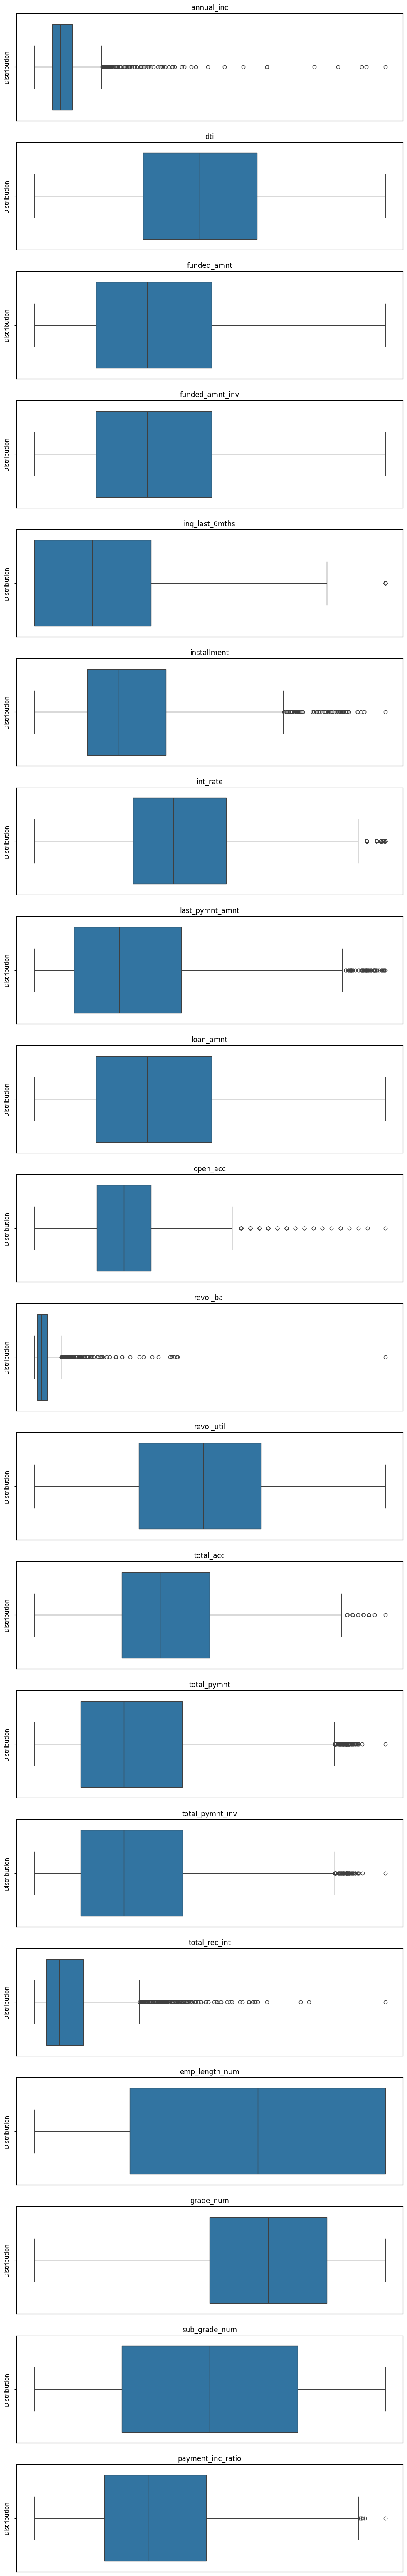

In [213]:
cols = numerical_features_f.columns
fig, axs = plt.subplots(len(cols),1,figsize=(12,80))

for col, ax in zip(cols, axs.ravel()):
  sns.boxplot(x=col, data=numerical_features_f, ax=ax)
  ax.set_ylabel("Distribution")
  ax.get_xaxis().set_visible(False)
  ax.set_title(col)

In [214]:
df_final_clean = modelOutlierDetection(df_final, numerical_features_f, n = 1000, drop = False)

Se han eliminado : 274 instancias.


### Encoding

In [215]:
categorical_features_f = df_final_clean.select_dtypes(include=[object])

In [216]:
#df_final_cod = binaryEncoding(df_final_clean, categorical_features_f)

In [217]:
df_final_cod = labelEncoding(df_final_clean, categorical_features_f)

In [218]:
df_final_cod.head()

,annual_inc,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,last_pymnt_amnt,loan_amnt,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,home_ownership_cod,initial_list_status_cod,loan_status_cod,purpose_cod,term_cod,status_cod
0,50000.0,3.19,12000,12000,2.0,275.20,13.35,11845.40,12000,9.0,3892,12.9,11.0,12395.80,12395.80,395.75,3,4,0.4,6.6048,0,0,2,3,1,2
1,40000.0,14.88,11725,11725,1.0,278.88,14.99,278.88,11725,7.0,10102,44.9,15.0,836.64,836.64,434.41,11,4,1.0,8.3664,0,1,0,2,1,0
2,32000.0,29.14,8500,8500,1.0,278.24,10.99,7388.06,8500,9.0,4586,34.2,11.0,9057.50,9057.50,557.50,5,5,0.6,10.4340,2,1,2,2,0,2
3,60000.0,24.02,10000,10000,0.0,330.57,11.67,9383.59,10000,11.0,6111,44.6,29.0,10375.30,10375.30,375.30,7,5,0.8,6.6114,0,0,2,3,0,2
4,40000.0,20.46,14400,14400,1.0,517.50,17.57,13008.90,14400,18.0,15333,34.2,34.0,15596.40,15596.40,1196.36,5,3,0.8,15.5250,1,1,2,3,0,2


In [219]:
df_final_cod.dtypes

annual_inc                 float64
dti                        float64
funded_amnt                  int64
funded_amnt_inv              int64
inq_last_6mths             float64
installment                float64
int_rate                   float64
last_pymnt_amnt            float64
loan_amnt                    int64
open_acc                   float64
revol_bal                    int64
revol_util                 float64
total_acc                  float64
total_pymnt                float64
total_pymnt_inv            float64
total_rec_int              float64
emp_length_num               int64
grade_num                    int64
sub_grade_num              float64
payment_inc_ratio          float64
home_ownership_cod           int64
initial_list_status_cod      int64
loan_status_cod              int64
purpose_cod                  int64
term_cod                     int64
status_cod                   int64
dtype: object

### Scaler

In [220]:
std_scaler = StandardScaler()
inf = {}
for i in df_final_cod.columns:
    inf[i+"scl"] = std_scaler.fit_transform(df_final_cod[[i]]).reshape(-1)

df_final_scl = pd.DataFrame(inf)

df_final_scl.head()

,annual_incscl,dtiscl,funded_amntscl,funded_amnt_invscl,inq_last_6mthsscl,installmentscl,int_ratescl,last_pymnt_amntscl,loan_amntscl,open_accscl,revol_balscl,revol_utilscl,total_accscl,total_pymntscl,total_pymnt_invscl,total_rec_intscl,emp_length_numscl,grade_numscl,sub_grade_numscl,payment_inc_ratioscl,home_ownership_codscl,initial_list_status_codscl,loan_status_codscl,purpose_codscl,term_codscl,status_codscl
0,-0.488503,-1.753628,-0.173370,-0.172667,0.845948,-0.558332,-0.220311,0.193010,-0.173370,-0.467098,-0.573197,-1.536423,-1.333999,-0.008395,-0.007755,-0.456690,-1.003389,0.045389,-0.736692,-0.202412,-0.955191,-1.181595,0.370480,0.216783,1.641518,0.370480
1,-0.685636,-0.225984,-0.207027,-0.206337,-0.007396,-0.542630,0.152526,-1.203950,-0.207027,-0.849809,-0.221481,-0.227650,-0.995664,-1.282985,-1.282872,-0.399738,1.104387,0.045389,1.370818,0.252056,-0.955191,0.846314,-2.742801,-0.287754,1.641518,-2.742801
2,-0.843342,1.637507,-0.601725,-0.601197,-0.007396,-0.545361,-0.756833,-0.345331,-0.601725,-0.467098,-0.533891,-0.665271,-1.333999,-0.376498,-0.376010,-0.218409,-0.476445,0.781427,-0.034188,0.785467,1.162749,0.846314,0.370480,-0.287754,-0.609192,0.370480
3,-0.291371,0.968428,-0.418144,-0.417541,-0.860739,-0.322070,-0.602242,-0.104318,-0.418144,-0.084388,-0.447519,-0.239919,0.188509,-0.231189,-0.230641,-0.486816,0.050499,0.781427,0.668315,-0.200709,-0.955191,-1.181595,0.370480,0.216783,-0.609192,0.370480
4,-0.685636,0.503208,0.120358,0.121182,-0.007396,0.475556,0.739063,0.333533,0.120358,1.255099,0.074788,-0.665271,0.611428,0.344525,0.345311,0.722723,-0.476445,-0.690649,0.668315,2.098873,0.103779,0.846314,0.370480,0.216783,-0.609192,0.370480


In [221]:
df_final_scl.describe()

,annual_incscl,dtiscl,funded_amntscl,funded_amnt_invscl,inq_last_6mthsscl,installmentscl,int_ratescl,last_pymnt_amntscl,loan_amntscl,open_accscl,revol_balscl,revol_utilscl,total_accscl,total_pymntscl,total_pymnt_invscl,total_rec_intscl,emp_length_numscl,grade_numscl,sub_grade_numscl,payment_inc_ratioscl,home_ownership_codscl,initial_list_status_codscl,loan_status_codscl,purpose_codscl,term_codscl,status_codscl
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,-1.657933e-17,1.598721e-16,-9.592327e-17,2.368476e-18,2.605323e-17,-5.210647e-17,-4.500104e-17,6.868580e-17,-9.592327e-17,-1.486219e-16,-1.509903e-17,1.657933e-16,-1.113184e-16,-4.440892e-17,-1.912544e-16,1.894781e-17,-8.052818e-17,-9.000208e-17,-7.105427e-18,4.204045e-17,-3.789561e-17,0.000000,-6.631732e-17,8.763360e-17,1.953993e-17,-6.631732e-17
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00
min,-1.316460e+00,-2.170496e+00,-1.519627e+00,-1.519476e+00,-8.607392e-01,-1.598110e+00,-1.884438e+00,-1.237632e+00,-1.519627e+00,-1.997940e+00,-7.936291e-01,-2.064023e+00,-2.095254e+00,-1.375239e+00,-1.375163e+00,-1.039686e+00,-1.793805e+00,-2.898763e+00,-1.439195e+00,-1.789116e+00,-9.551905e-01,-1.181595,-2.742801e+00,-1.296828e+00,-6.091922e-01,-2.742801e+00
25%,-5.407535e-01,-7.529491e-01,-7.853054e-01,-7.848528e-01,-8.607392e-01,-7.334919e-01,-6.022420e-01,-7.478303e-01,-7.853054e-01,-6.584533e-01,-5.181035e-01,-7.675187e-01,-7.419128e-01,-7.616066e-01,-7.619521e-01,-6.959101e-01,-1.003389e+00,-6.906489e-01,-7.366917e-01,-7.837751e-01,-9.551905e-01,-1.181595,3.704805e-01,-2.877542e-01,-6.091922e-01,3.704805e-01
50%,-2.125178e-01,-1.820323e-02,-1.794897e-01,-1.787889e-01,-7.395644e-03,-2.408906e-01,-7.708713e-02,-1.883126e-01,-1.794897e-01,-8.438765e-02,-2.480718e-01,3.001517e-02,-1.498261e-01,-1.987977e-01,-1.982364e-01,-3.112908e-01,5.049879e-02,4.538900e-02,-3.418849e-02,-1.609303e-01,1.037790e-01,0.846314,3.704805e-01,-2.877542e-01,-6.091922e-01,3.704805e-01
75%,2.803137e-01,7.269970e-01,5.854291e-01,5.864434e-01,8.459479e-01,5.338326e-01,6.072056e-01,5.719391e-01,5.854291e-01,4.896780e-01,1.956237e-01,7.457507e-01,6.114282e-01,5.671204e-01,5.679979e-01,3.587390e-01,1.104387e+00,7.814269e-01,6.683147e-01,6.722245e-01,1.162749e+00,0.846314,3.704805e-01,-2.877542e-01,1.641518e+00,3.704805e-01
max,1.331078e+01,2.396755e+00,2.641531e+00,2.643388e+00,4.259322e+00,4.082006e+00,2.669177e+00,3.077568e+00,2.641531e+00,5.464914e+00,2.537704e+01,2.283560e+00,3.318110e+00,3.228474e+00,3.227163e+00,8.905106e+00,1.104387e+00,1.517465e+00,1.370818e+00,3.231431e+00,1.162749e+00,0.846314,3.704805e-01,3.748541e+00,1.641518e+00,3.704805e-01


### **Final Prediction**

In [222]:
prediccion_final = best_model.predict(df_final_scl)

In [223]:
prediccion_final

array([0, 1, 0, ..., 0, 0, 0])

In [224]:
y_results = pd.DataFrame({"results": prediccion_final})
y_results.to_csv("final_prediction.csv", index=False)

## -------------------

# **MLFLOW & DOCKER**

In [225]:
import mlflow

mlflow_url = 'http://localhost:5000'

mlflow.set_tracking_uri(mlflow_url)

In [226]:
experiment_name = 'First_model'

#experiment_id = mlflow.create_experiment(experiment_name)

In [227]:
EXPERIMENT_NAME = experiment_name
RUN_NAME = "GradientBoosting"

MLFLOW_TRACKING_URI = "http://localhost:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

experiment_id = experiment.experiment_id

with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=RUN_NAME,
) as run:
    
        mlflow.set_tags({
        "model_type": "GradientBoostingClassifier"
        })
    
        mlflow.log_param("learning_rate", 0.1)
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("subsample", 1.0)

        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1", f1)

        mlflow.log_artifact(image_path)

        mlflow.sklearn.log_model(best_model, "model")

## REGISTER THE MODEL BY CODING

In [228]:
run_id = run.info.run_id
run_id

'3229799ae28b4c5abbec22160e499870'

In [229]:
MODEL_NAME = EXPERIMENT_NAME

model_path = f"runs:/{run_id}/model"

In [230]:
result = mlflow.register_model(model_path, MODEL_NAME)
print(f" Registered model version: {result.version}!")

Registered model 'First_model' already exists. Creating a new version of this model...
2024/03/16 20:03:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: First_model, version 5


 Registered model version: 5!


Created version '5' of model 'First_model'.


## DEPLOY THE MODEL

- **Use of MLflow directly on the host system**

1. export MLFLOW_TRACKING_URI=http://localhost:5000

2. mlflow models serve --model-uri models:/<model_name>/<model_version> --port 5001 --env-manager conda

- **Using Docker to contain MLflow**

docker run --net host --env MLFLOW_TRACKING_URI=http://localhost:5000 ghcr.io/mlflow/mlflow:v2.10.2 mlflow models serve --model-uri models:/<model_name>/<version> --port 5001 --env-manager local

## PREPARE THE DATA TO BE SENT

- Create the **headers**
- Create the **body**

In [231]:
X_test_values = df_final_scl.values.tolist()

In [232]:
headers = {"content-type": "application/json"}

body = {"inputs": X_test_values}

In [233]:
import json

body_json = json.dumps(body) #Convert python data to JSON data

## SEND THE REQUEST

In [234]:
import requests

ENDPOINT = 'http://localhost:5001/invocations'

response = requests.post(ENDPOINT, data=body_json, headers=headers)

response

<Response [200]>

In [237]:
response.json()

{'predictions': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [236]:
response.status_code

200

---------------------------